In [1]:
import scipy
import pandas as pd
import numpy as np
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
if not os.path.exists('qm7.mat'):
  os.system('wget http://www.quantum-machine.org/data/qm7.mat')

data = scipy.io.loadmat('qm7.mat')

# Reshape the Coulomb Matrix
X = data['X'].reshape((7165, 23, 23, 1))
X = torch.tensor(X,dtype=torch.float32).permute(0,3,1,2)

# Normalize y
y = data['T'].reshape(-1,)
y_scaling_factor = np.max(np.absolute(y))
y_scaled = y/y_scaling_factor
y_scaled = torch.tensor(y_scaled,dtype=torch.float32).unsqueeze(1)

rand_state = 42
# Create pytorch dataset
dataset = TensorDataset(X,y_scaled)

In [3]:
# Define the model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        torch.manual_seed(rand_state)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=7, padding='same')
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(15488, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Initialize the model, loss function and optimizer
model = ConvNet().to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.L1Loss(reduction='sum')

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=15488, out_features=1, bias=True)
  (relu): ReLU()
)


In [4]:
NUM_EPOCHS = 20

# Define training function
def train(model,criterion,optimizer,train_loader):
    # Set model to training mode
    model.train()
    # Monitoring average loss for one epoch
    running_loss = 0.0
    for data,target in train_loader:  # Iterate in batches over the training dataset.
      # Move the input data to the specified device (CPU or GPU)
      data = data.to(device)
      # Move the target labels to the specified device (CPU or GPU)
      target = target.to(device)
      # Reset the gradients of all the parameters to zero before backpropagation
      optimizer.zero_grad()
      # Perform a forward pass through the model to get the output predictions
      output = model(data)
      # Compute the loss between the model's output and the target labels
      loss = criterion(output, target)
      # Perform backpropagation to compute the gradients of the loss with respect to the model parameters
      loss.backward()
      # Update the model parameters using the computed gradients
      optimizer.step()
      # Accumulate the loss value for monitoring
      running_loss += loss.item()
    # Return the average running loss over the entire dataset
    return running_loss / len(train_loader.dataset)

# Define validation function
def val(model,criterion,val_loader):
    # Set model to evaluation mode
    model.eval()
    # Monitoring average loss for one epoch
    running_loss = 0.0
    for data,target in val_loader:
        # Move the input data to the specified device (CPU or GPU)
        data = data.to(device)
        # Move the target labels to the specified device (CPU or GPU)
        target=target.to(device)
        # Perform a forward pass through the model to get the output predictions
        output = model(data)
        # Compute the loss between the model's output and the target labels
        loss = criterion(output, target)
        # Accumulate the loss value for monitoring
        running_loss += loss.item()
    # Return the average running loss over the entire dataset
    return running_loss/len(val_loader.dataset)

In [5]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        # Initialize the EarlyStopper with a specified patience and minimum delta
        self.patience = patience  # Number of epochs with no improvement after which training will be stopped
        self.min_delta = min_delta  # Minimum change in the monitored quantity to qualify as an improvement
        self.counter = 0  # Counter to keep track of epochs with no improvement
        self.min_validation_loss = float('inf')  # Best observed validation loss initialized to infinity

    def early_stop(self, validation_loss):
        # Check if the validation loss has improved
        if validation_loss < self.min_validation_loss:
            # If validation loss has improved, update the best observed validation loss and reset the counter
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            # If validation loss has not improved and exceeds the threshold (min_validation_loss + min_delta)
            # increment the counter
            self.counter += 1
            # If the counter exceeds the patience, return True to indicate early stopping
            if self.counter >= self.patience:
                return True
        # Return False to indicate no early stopping
        return False


In [6]:
# train_score,val_score = crossvalid(model,criterion,optimizer,dataset=dataset,indices=data['P'])
def crossvalid(model=None, criterion=None, optimizer=None, dataset=None, indices=None):
    # Make a deep copy of the model's initial state dictionary (weights)
    model_wts = copy.deepcopy(model.state_dict())
    # Initialize series to store training and validation scores
    train_score =  []
    val_score = []

    # Perform 5-fold cross-validation
    for i in range(5):

        print(f"============Fold {i+1}============")

        # Load the initial weights into the model before each fold
        model.load_state_dict(model_wts)

        # Prepare training and validation indices for the current fold
        train_indices = indices[list(range(0, i)) + list(range(i + 1, 5))].reshape(-1)
        val_indices = indices[i]

        # Create training and validation subsets using the prepared indices
        train_set = torch.utils.data.dataset.Subset(dataset, train_indices)
        val_set = torch.utils.data.dataset.Subset(dataset, val_indices)

        # Create data loaders for training and validation sets
        train_loader = DataLoader(train_set, batch_size=20, shuffle=True)
        val_loader = DataLoader(val_set, batch_size=20, shuffle=False)

        # Lists to store the loss values for each epoch
        loss_epoch_trn_list = []
        val_epoch_trn_list = []

        # Training loop for the current fold
        for epoch in range(NUM_EPOCHS):
            # Train the model and calculate training loss
            train_loss = train(model, criterion, optimizer, train_loader)
            loss_epoch_trn_list.append(train_loss)

            # Validate the model and calculate validation loss
            val_loss = val(model, criterion, val_loader)
            val_epoch_trn_list.append(val_loss)

            # Print the loss values for the current epoch
            print("Epoch: {}, Train Loss: {}, Test Loss: {}".format(epoch + 1, train_loss, val_loss))

        # Store the final training and validation loss for the current fold
        train_score.append(loss_epoch_trn_list)
        val_score.append(val_epoch_trn_list)

    # Return the training and validation scores for all folds
    return train_score, val_score

# Call the cross-validation function with the model, criterion, optimizer, dataset, and indices
train_score, val_score = crossvalid(model, criterion, optimizer, dataset=dataset, indices=data['P'])


============Fold 1============
Epoch: 1, Train Loss: 0.05757158786703138, Test Loss: 0.015599735450345324
Epoch: 2, Train Loss: 0.01918147304676998, Test Loss: 0.022348116264423123
Epoch: 3, Train Loss: 0.01562440835734971, Test Loss: 0.02254900881151012
Epoch: 4, Train Loss: 0.01410642155008722, Test Loss: 0.02728716171212073
Epoch: 5, Train Loss: 0.013624553762984624, Test Loss: 0.007387136079927299
Epoch: 6, Train Loss: 0.010425965234751644, Test Loss: 0.014225340937702953
Epoch: 7, Train Loss: 0.010158865276492731, Test Loss: 0.008003198177100726
Epoch: 8, Train Loss: 0.0114242457326525, Test Loss: 0.012697627992789727
Epoch: 9, Train Loss: 0.009913039400872034, Test Loss: 0.018023372133212413
Epoch: 10, Train Loss: 0.010029580935430294, Test Loss: 0.007857636324359417
Epoch: 11, Train Loss: 0.009191650385134552, Test Loss: 0.007428201506874899
Epoch: 12, Train Loss: 0.009486021514298278, Test Loss: 0.006620300352698178
Epoch: 13, Train Loss: 0.009317634072198955, Test Loss: 0.0071

In [7]:
print(f"Average train loss: {np.mean([score[-1] for score in train_score])*y_scaling_factor}")
print(f"Average test loss: {np.mean([score[-1] for score in val_score])*y_scaling_factor}")


Average train loss: 16.778827704987325
Average test loss: 22.16096877412869


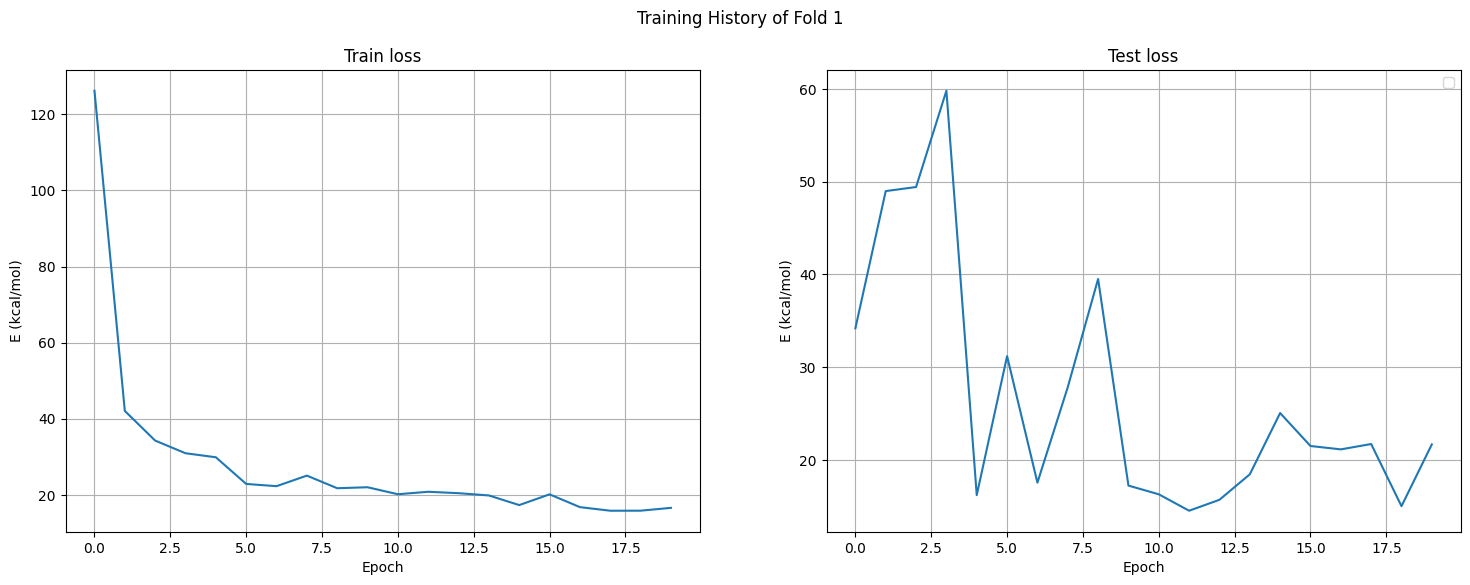

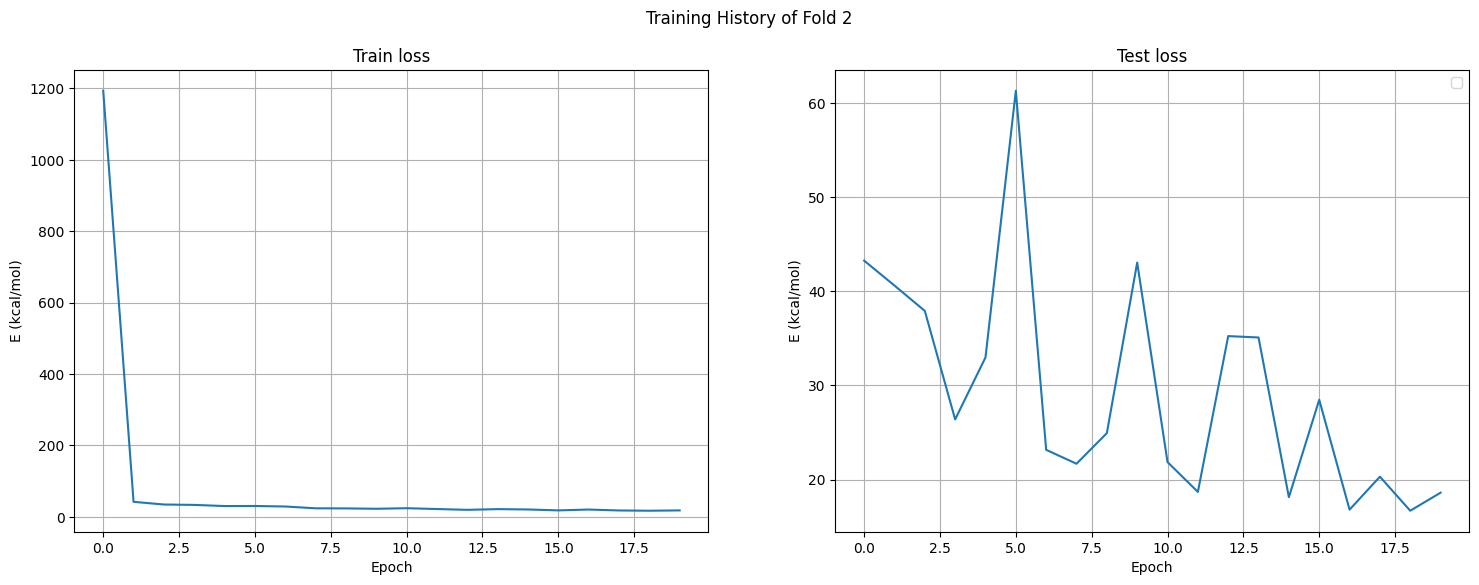

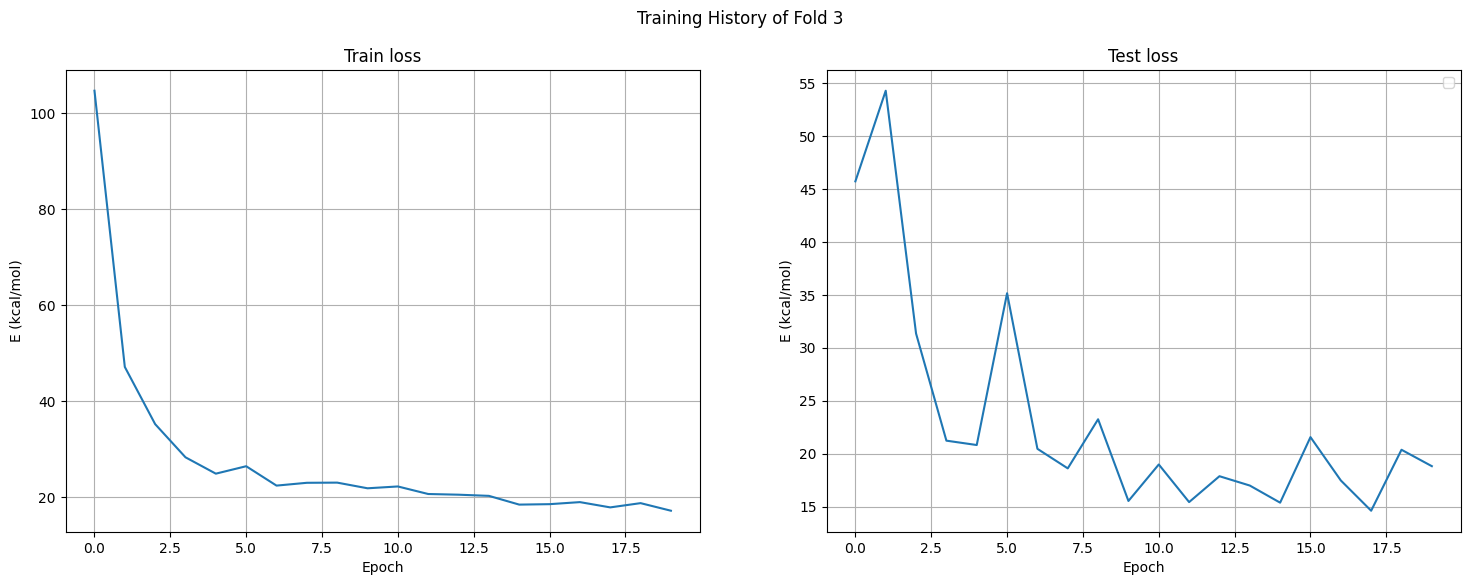

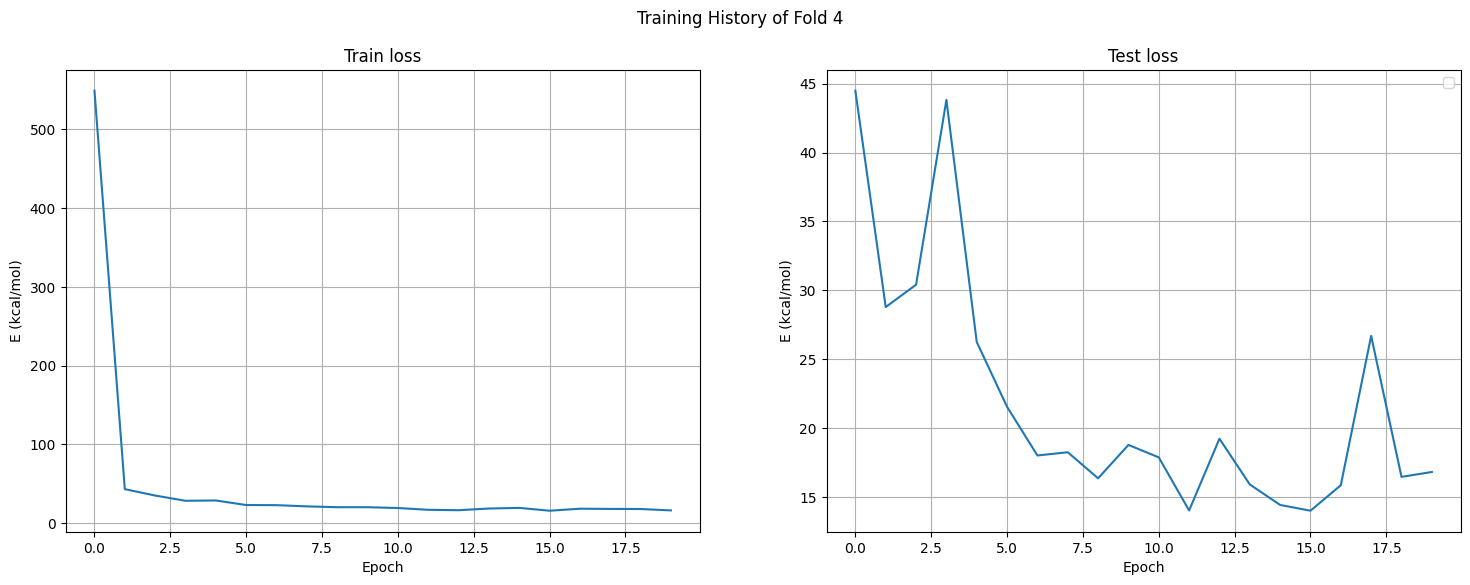

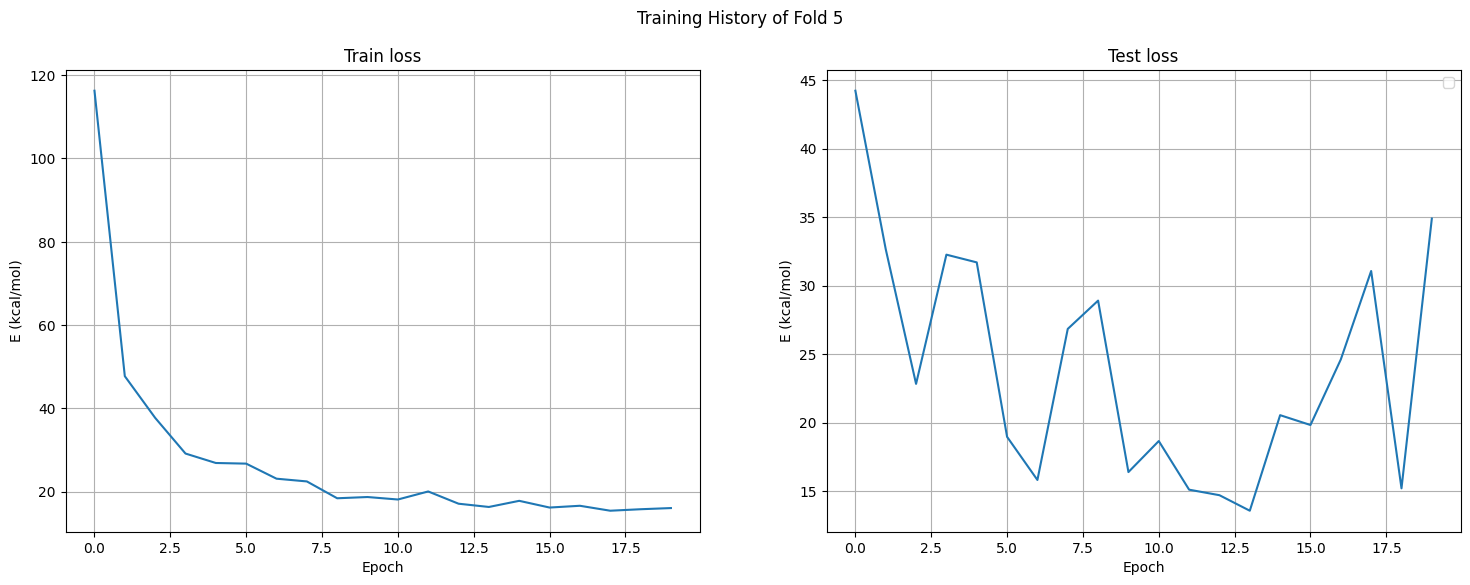

In [8]:
from matplotlib import pyplot as plt

for i in range(5):
# Plot training history
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
  fig.suptitle(f'Training History of Fold {i+1}')
  ax1.plot([score*y_scaling_factor for score in train_score[i]])
  ax1.set_title("Train loss")
  ax2.plot([score*y_scaling_factor for score in val_score[i]])
  ax2.set_title("Test loss")
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('E (kcal/mol)')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('E (kcal/mol)')
  plt.legend()
  ax1.grid(True)
  ax2.grid(True)